<a href="https://colab.research.google.com/github/fepegar/torchio-notebooks/blob/main/notebooks/TorchIO_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TorchIO: a tutorial

In this tutorial, we will train a [3D U-Net](https://link.springer.com/chapter/10.1007/978-3-319-46723-8_49) to perform brain segmentation from T1-weighted MRI using the [Information eXtraction from Images (IXI) dataset](https://brain-development.org/ixi-dataset/), a publicly available dataset of almost 600 subjects.

## Setup

In [48]:
# Config
seed = 42  # for reproducibility
training_split_ratio = 0.9  # use 90% of samples for training, 10% for testing
num_epochs = 5

# If the following values are False, the models will be downloaded and not computed
compute_histograms = False
train_whole_images = False 
train_patches = True

Install some PyPI packages:

In [3]:
!git clone https://github.com/fepegar/torchio.git --depth 1 repo
!pip install --quiet --upgrade pip
!pip install -e ./repo
import sys; sys.path.append('repo')

fatal: destination path 'repo' already exists and is not an empty directory.
     |████████████████████████████████| 1.5 MB 8.9 MB/s 
Obtaining file:///content/repo
  Attempting uninstall: torchio
    Found existing installation: torchio 0.18.19
    Can't uninstall 'torchio'. No files were found to uninstall.
  Running setup.py develop for torchio


In [4]:
!pip install --quiet --upgrade pip
!pip install --quiet unet==0.7.7
#!pip install --quiet torchio==0.18.19
!apt -qq install tree

The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 13 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Selecting previously unselected package tree.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


Import modules:

In [25]:
import copy
import enum
import time
import random; random.seed(seed)
import tempfile
import multiprocessing
from pathlib import Path

import torch
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image

import torchio as tio

import numpy as np
import nibabel as nib
from unet import UNet
from scipy import stats
import SimpleITK as sitk
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm

torch.manual_seed(seed)
%config InlineBackend.figure_format = 'retina'

print('TorchIO version:', tio.__version__)

TorchIO version: 0.18.19


## Data

### Dataset

I downloaded the [IXI](https://brain-development.org/ixi-dataset/) dataset, segmented all brains using [ROBEX](https://ieeexplore.ieee.org/document/5742706), affine-registered everything to an MNI template with [NiftyReg](https://github.com/KCL-BMEIS/niftyreg), resampled everything into a space with a very large voxel spacing and funny orientation with [ITK](https://itk.org/) and uploaded a zip file to Dropbox.
It will be our medical image MNIST.

In [7]:
# Dataset
dataset_url = 'https://www.dropbox.com/s/ogxjwjxdv5mieah/ixi_tiny.zip?dl=0'
dataset_path = 'ixi_tiny.zip'
dataset_dir_name = 'ixi_tiny'
dataset_dir = Path(dataset_dir_name)
histogram_landmarks_path = 'landmarks.npy'

In [8]:
if not dataset_dir.is_dir():
    !curl --silent --output {dataset_path} --location {dataset_url} 
    !unzip -qq {dataset_path}
!tree -d {dataset_dir_name}

ixi_tiny
├── image
└── label

2 directories


### [`SubjectsDataset`](https://torchio.readthedocs.io/data/dataset.html)

This is one of the most important classes in the library. It inherits from `torch.utils.data.Dataset`. It receives as input a list of [`torchio.Subject`](https://torchio.readthedocs.io/data/subject.html#subject) instances and an optional [`torchio.transforms.Transform`](https://torchio.readthedocs.io/transforms/transforms.html#torchio.transforms.Transform). 

The inputs to the subject class are instances of `torchio.Image`, such as [`torchio.ScalarImage`](https://torchio.readthedocs.io/data/image.html#scalarimage) or [`torchio.LabelMap`](https://torchio.readthedocs.io/data/image.html#labelmap). The image class will be used by the transforms to decide whether or not to perform the operation. For example, spatial transforms must apply to both, but intensity transforms must apply to scalar images only.

In [9]:
images_dir = dataset_dir / 'image'
labels_dir = dataset_dir / 'label'
image_paths = sorted(images_dir.glob('*.nii.gz'))
label_paths = sorted(labels_dir.glob('*.nii.gz'))
assert len(image_paths) == len(label_paths)

subjects = []
for (image_path, label_path) in zip(image_paths, label_paths):
    subject = tio.Subject(
        mri=tio.ScalarImage(image_path),
        brain=tio.LabelMap(label_path),
    )
    subjects.append(subject)
dataset = tio.SubjectsDataset(subjects)
print('Dataset size:', len(dataset), 'subjects')

Dataset size: 566 subjects


Let's take a look into the sample returned by the dataset:

Subject(Keys: ('mri', 'brain'); images: 2)
ScalarImage(shape: (1, 83, 44, 55); spacing: (2.18, 4.13, 3.95); orientation: SRA+; memory: 784.6 KiB; dtype: torch.ShortTensor)


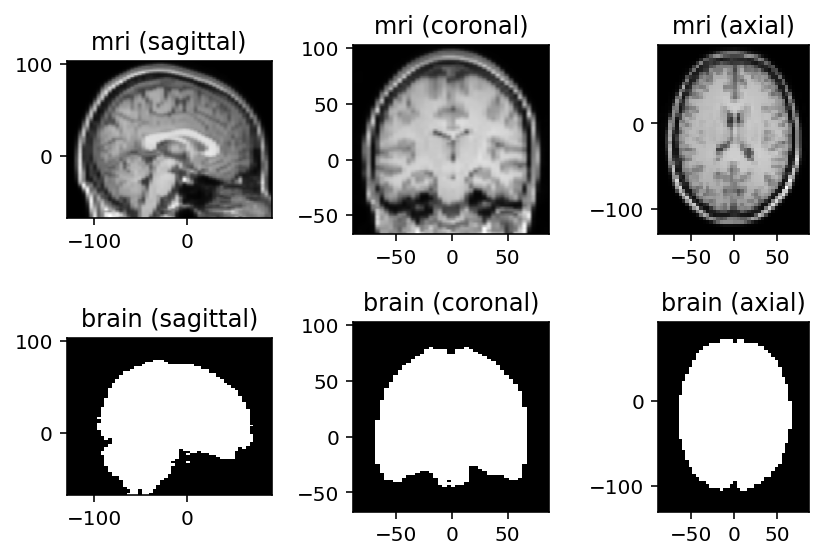

In [10]:
one_subject = dataset[0]
print(one_subject)
print(one_subject.mri)
one_subject.plot()

## [Transforms](https://torchio.readthedocs.io/transforms/transforms.html#transforms)

For a full tutorial on TorchIO transforms, check out our [Data preprocessing and augmentation using TorchIO](https://github.com/fepegar/torchio/blob/master/examples/README.md) tutorial.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/fepegar/torchio/blob/master/examples/README.md)

#### Normalization

We will use the [`HistogramStandardization`]() and the [`ZNormalization`]() transforms to normalize our images intensity.

The images have been acquired by different MRI scanners at different hospitals. We will apply some normalization techniques so that intensities are similarly distributed and within similar ranges.

Training the histogram is typically quite fast. It takes long here because of the fancy plotting.

In [11]:
paths = image_paths

def plot_histogram(axis, tensor, num_positions=100, label=None, alpha=0.05, color=None):
    values = tensor.numpy().ravel()
    kernel = stats.gaussian_kde(values)
    positions = np.linspace(values.min(), values.max(), num=num_positions)
    histogram = kernel(positions)
    kwargs = dict(linewidth=1, color='black' if color is None else color, alpha=alpha)
    if label is not None:
        kwargs['label'] = label
    axis.plot(positions, histogram, **kwargs)

if compute_histograms:
    fig, ax = plt.subplots(dpi=100)
    for path in tqdm(paths):
        tensor = tio.ScalarImage(path).data
        if 'HH' in path.name: color = 'red'
        elif 'Guys' in path.name: color = 'green'
        elif 'IOP' in path.name: color = 'blue'
        plot_histogram(ax, tensor, color=color)
    ax.set_xlim(-100, 2000)
    ax.set_ylim(0, 0.004);
    ax.set_title('Original histograms of all samples')
    ax.set_xlabel('Intensity')
    ax.grid()
    graph = None
else:
    graph = display.Image(url='https://www.dropbox.com/s/daqsg3udk61v65i/hist_original.png?dl=1')
graph

In [12]:
landmarks = tio.HistogramStandardization.train(
    image_paths,
    output_path=histogram_landmarks_path,
)
np.set_printoptions(suppress=True, precision=3)
print('\nTrained landmarks:', landmarks)

100%|██████████| 566/566 [00:05<00:00, 98.80it/s] 



Trained landmarks: [ -0.      0.002   0.108   0.227   0.467   2.014  15.205  34.297  49.664
  55.569  61.178  74.005 100.   ]


In [13]:
landmarks_dict = {'mri': landmarks}
histogram_transform = tio.HistogramStandardization(landmarks_dict)

if compute_histograms:
    fig, ax = plt.subplots(dpi=100)
    for i ,sample in enumerate(tqdm(dataset)):
        standard = histogram_transform(sample)
        tensor = standard.mri.data
        path = str(sample.mri.path)
        if 'HH' in path: color = 'red'
        elif 'Guys' in path: color = 'green'
        elif 'IOP' in path: color = 'blue'
        plot_histogram(ax, tensor, color=color)
    ax.set_xlim(0, 150)
    ax.set_ylim(0, 0.02)
    ax.set_title('Intensity values of all samples after histogram standardization')
    ax.set_xlabel('Intensity')
    ax.grid()
    graph = None
else:
    graph = display.Image(url='https://www.dropbox.com/s/dqqaf78c86mrsgn/hist_standard.png?dl=1')
graph

##### Z-normalization

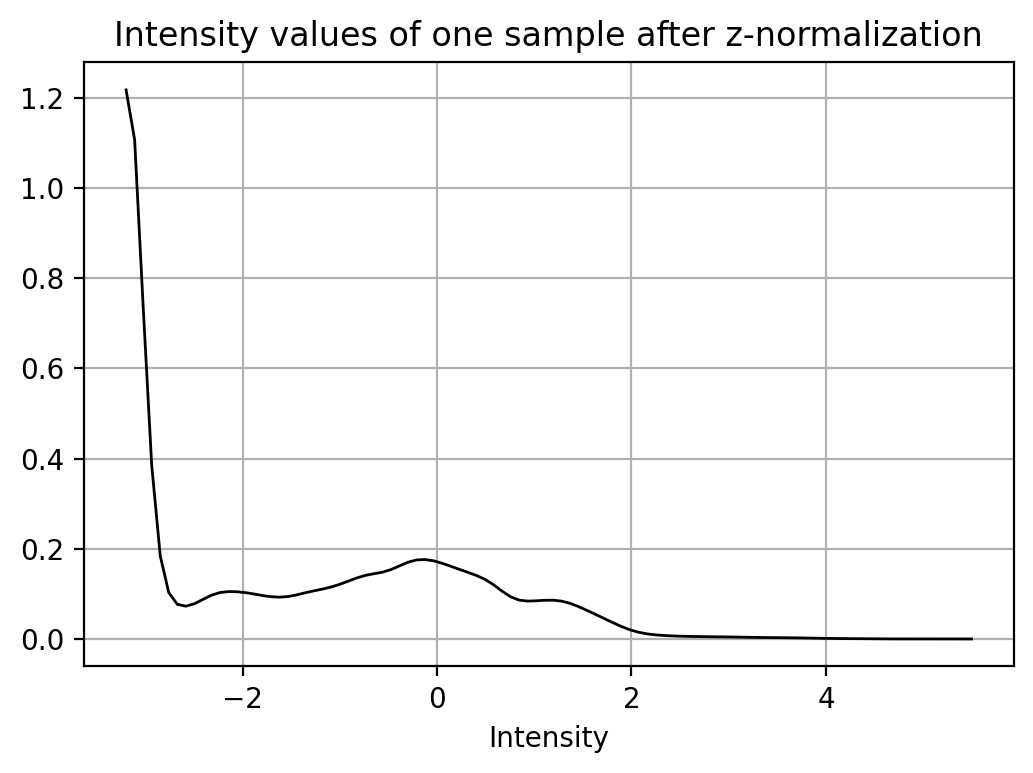

In [14]:
znorm_transform = tio.ZNormalization(masking_method=tio.ZNormalization.mean)

sample = dataset[0]
transform = tio.Compose([histogram_transform, znorm_transform])
znormed = transform(sample)

fig, ax = plt.subplots(dpi=100)
plot_histogram(ax, znormed.mri.data, label='Z-normed', alpha=1)
ax.set_title('Intensity values of one sample after z-normalization')
ax.set_xlabel('Intensity')
ax.grid()

## Training a network



In [15]:
training_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.RandomMotion(p=0.2),
    tio.HistogramStandardization({'mri': landmarks}),
    tio.RandomBiasField(p=0.3),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.RandomNoise(p=0.5),
    tio.RandomFlip(),
    tio.OneOf({
        tio.RandomAffine(): 0.8,
        tio.RandomElasticDeformation(): 0.2,
    }),
    tio.OneHot(),
])

validation_transform = tio.Compose([
    tio.ToCanonical(),
    tio.Resample(4),
    tio.CropOrPad((48, 60, 48)),
    tio.HistogramStandardization({'mri': landmarks}),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.OneHot(),
])

num_subjects = len(dataset)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects

num_split_subjects = num_training_subjects, num_validation_subjects
training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects)

training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

print('Training set:', len(training_set), 'subjects')
print('Validation set:', len(validation_set), 'subjects')

Training set: 509 subjects
Validation set: 57 subjects


### Deep learning stuff

In [26]:
#@title (Deep learning functions, double-click here to expand)
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4

class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'

def prepare_batch(batch, device):
    inputs = batch['mri'][tio.DATA].to(device)
    targets = batch['brain'][tio.DATA].to(device)
    return inputs, targets

def get_dice_score(output, target, epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum(dim=SPATIAL_DIMENSIONS)
    fp = (p0 * g1).sum(dim=SPATIAL_DIMENSIONS)
    fn = (p1 * g0).sum(dim=SPATIAL_DIMENSIONS)
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def get_dice_loss(output, target):
    return 1 - get_dice_score(output, target)

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=2,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    times = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = model(inputs)
            probabilities = F.softmax(logits, dim=CHANNELS_DIMENSION)
            batch_losses = get_dice_loss(probabilities, targets)
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            times.append(time.time())
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f'{action.value} mean loss: {epoch_losses.mean():0.3f}')
    return times, epoch_losses

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    train_losses = []
    val_losses = []
    val_losses.append(run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer))
    for epoch_idx in range(1, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        train_losses.append(run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer))
        val_losses.append(run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer))
        torch.save(model.state_dict(), f'{weights_stem}_epoch_{epoch_idx}.pth')
    return np.array(train_losses), np.array(val_losses)

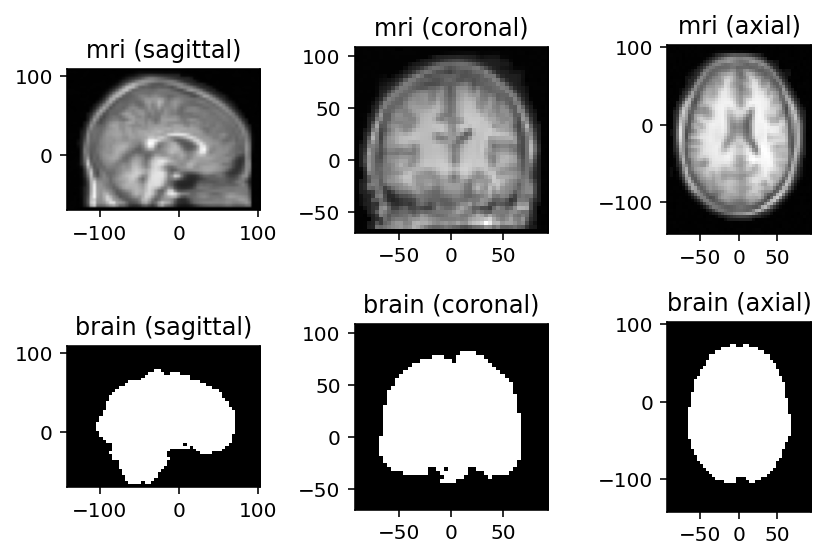

In [17]:
training_instance = training_set[42]  # transform is applied in SubjectsDataset
training_instance.plot()

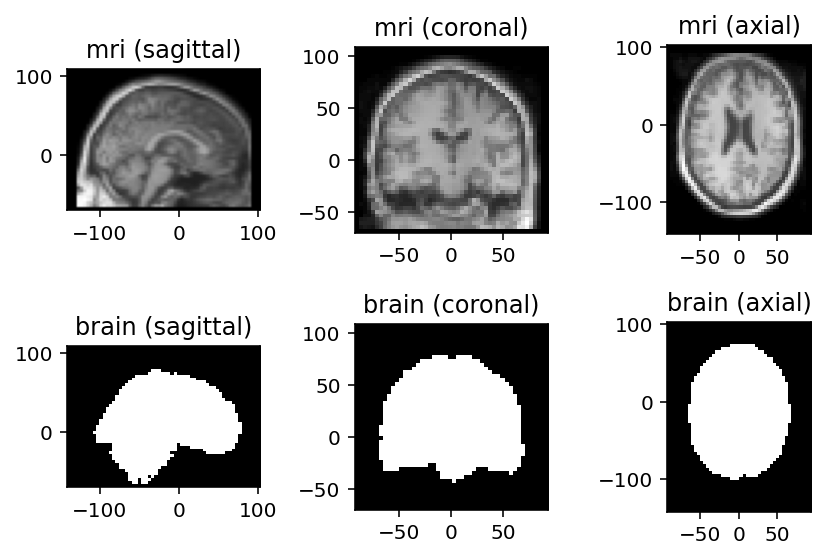

In [18]:
validation_instance = validation_set[42]
validation_instance.plot()

### Whole images

In [19]:
training_batch_size = 16
validation_batch_size = 2 * training_batch_size

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
    num_workers=multiprocessing.cpu_count(),
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
    num_workers=multiprocessing.cpu_count(),
)

Visualize axial slices of one batch

In [20]:
one_batch = next(iter(training_loader))

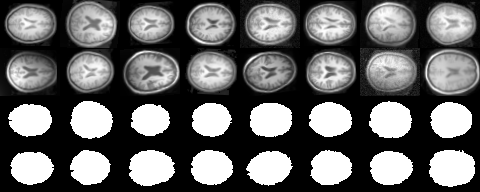

In [21]:
k = 24
batch_mri = one_batch['mri'][tio.DATA][..., k]
batch_label = one_batch['brain'][tio.DATA][:, 1:, ..., k]
slices = torch.cat((batch_mri, batch_label))
image_path = 'batch_whole_images.png'
save_image(slices, image_path, nrow=training_batch_size//2, normalize=True, scale_each=True, padding=0)
display.Image(image_path)

#### Train

In [27]:
model, optimizer = get_model_and_optimizer(device)
weights_path = 'whole_image_state_dict.pth'
if train_whole_images:
    weights_stem = 'whole_images'
    train_losses, val_losses = train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem)
    checkpoint = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'weights': model.state_dict(),
    }
    torch.save(checkpoint, weights_path)
else:
    weights_path = 'whole_image_state_dict.pth'
    weights_url = 'https://github.com/fepegar/torchio-data/raw/master/models/whole_images_epoch_5.pth'
    !curl --location --silent --output {weights_path} {weights_url}
    checkpoint = torch.load(weights_path)
    model.load_state_dict(checkpoint['weights'])
    train_losses, val_losses = checkpoint['train_losses'], checkpoint['val_losses'])
fig, ax = plt.subplots()
times, losses = train_losses.transpose(1, 0, 2)
ax.plot(times.flatten(), losses.flatten())
times, losses = val_losses.transpose(1, 0, 2)
ax.plot(times.flatten(), losses.flatten())
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Dice loss');


Validation mean loss: 0.542
Starting epoch 1



Training mean loss: 0.277



Validation mean loss: 0.234
Starting epoch 2



Training mean loss: 0.184



Validation mean loss: 0.150
Starting epoch 3



Training mean loss: 0.131



Validation mean loss: 0.118
Starting epoch 4



Training mean loss: 0.094



Validation mean loss: 0.070
Starting epoch 5



Training mean loss: 0.070



Validation mean loss: 0.054


Text(0, 0.5, 'Dice loss')

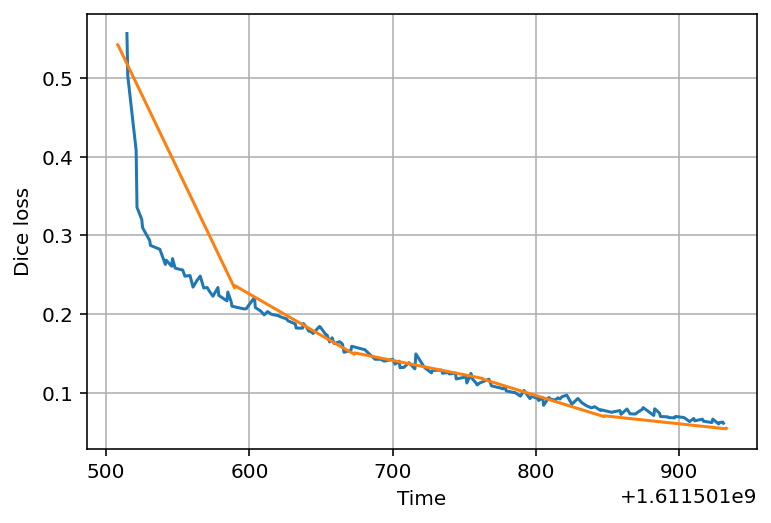

#### Test

In [ ]:
batch = next(iter(validation_loader))
model.eval()
inputs, targets = prepare_batch(batch, device)
FIRST = 0
FOREGROUND = 1
with torch.no_grad():
    probabilities = model(inputs).softmax(dim=1)[:, FOREGROUND:].cpu()
affine = batch['mri'][tio.AFFINE][0].numpy()
subject = tio.Subject(
    mri=tio.ScalarImage(tensor=batch['mri'][tio.DATA][FIRST], affine=affine),
    label=tio.LabelMap(tensor=batch['brain'][tio.DATA][FIRST], affine=affine),
    predicted=tio.ScalarImage(tensor=probabilities[FIRST], affine=affine),
)
subject.plot()
plt.tight_layout()

### Patch-based

In [ ]:
training_batch_size = 32
validation_batch_size = 2 * training_batch_size

patch_size = 24
samples_per_volume = 5
max_queue_length = 300

patches_training_set = tio.Queue(
    subjects_dataset=training_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=tio.data.UniformSampler(patch_size),
    num_workers=multiprocessing.cpu_count(),
    shuffle_subjects=True,
    shuffle_patches=True,
)

patches_validation_set = tio.Queue(
    subjects_dataset=validation_set,
    max_length=max_queue_length,
    samples_per_volume=samples_per_volume,
    sampler=tio.data.UniformSampler(patch_size),
    num_workers=multiprocessing.cpu_count(),
    shuffle_subjects=False,
    shuffle_patches=False,
)

training_loader = torch.utils.data.DataLoader(
    patches_training_set, batch_size=training_batch_size)

validation_loader = torch.utils.data.DataLoader(
    patches_validation_set, batch_size=validation_batch_size)

Visualize axial slices of one batch

In [ ]:
one_batch = next(iter(training_loader))
k = int(patch_size // 4)
batch_mri = one_batch['mri'][tio.DATA][..., k]
batch_label = one_batch['brain'][tio.DATA][..., k]
slices = torch.cat((batch_mri, batch_label))
image_path = 'batch_patches.png'
save_image(slices, image_path, nrow=training_batch_size, normalize=True, scale_each=True)
display.Image(image_path)

Train

In [ ]:
model, optimizer = get_model_and_optimizer(device)

if train_patches:
    weights_stem = 'patches'
    train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem)
else:
    weights_path = 'patches_state_dict.pth'
    weights_url = 'https://github.com/fepegar/torchio-data/raw/master/models/patches_epoch_5.pth'
    !curl --location --silent --output {weights_path} {weights_url}
    model.load_state_dict(torch.load(weights_path))

Infer

In [ ]:
sample = random.choice(validation_set)
input_tensor = sample.mri.data[0]
patch_size = 48, 48, 48  # we can user larger patches for inference
patch_overlap = 4, 4, 4
grid_sampler = tio.inference.GridSampler(
    sample,
    patch_size,
    patch_overlap,
)
patch_loader = torch.utils.data.DataLoader(
    grid_sampler, batch_size=validation_batch_size)
aggregator = tio.inference.GridAggregator(grid_sampler)

model.eval()
with torch.no_grad():
    for patches_batch in patch_loader:
        inputs = patches_batch['mri'][tio.DATA].to(device)
        locations = patches_batch[tio.LOCATION]
        logits = model(inputs)
        labels = logits.argmax(dim=CHANNELS_DIMENSION, keepdim=True)
        aggregator.add_batch(labels, locations)

foreground = aggregator.get_output_tensor()
affine = sample.mri.affine
label_image = tio.io.nib_to_sitk(foreground, affine)
border = sitk.BinaryContour(label_image)
border_array, _ = tio.io.sitk_to_nib(border)
input_tensor[border_array > 0.5] = input_tensor.max()
nii = nib.Nifti1Image(input_tensor.numpy(), affine)
show_nifti(nii)